<a href="https://colab.research.google.com/github/Vikash-exe/Computer-Vision/blob/main/LULC_ResNet101_U_Net_Vikash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install --upgrade tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# ✅ STEP 1: Mount Google Drive and Unzip Dataset
from zipfile import ZipFile
import os

from google.colab import drive
drive.mount('/content/drive')

# Paths to your uploaded dataset zip file
zip_path = "/content/drive/MyDrive/Dataset.zip"  # Update if needed
extract_path = "/content/dataset"

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_dir = os.path.join(extract_path, "images")
mask_dir = os.path.join(extract_path, "masks")

image_dir = "/content/dataset/images"
mask_dir = "/content/dataset/masks"

In [ ]:
!ls /content/dataset
!ls /content/dataset/images
!ls /content/dataset/masks


Dataset loading and **preprocessing**

80-20 split

In [ ]:
# ✅ STEP 3: Define Preprocessing Functions
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

IMG_SIZE = 256
NUM_CLASSES = 8

category_colors = {
    1: (255, 0, 0),      # BUILTUP
    2: (255, 255, 0),    # VACANT LAND
    3: (0, 0, 255),      # WATER
    4: (128, 64, 128),   # ROAD
    5: (64, 0, 128),     # SHADOW
    6: (128, 0, 0),      # PAVED AREAS
    7: (0, 255, 0),      # VEGETATION
    8: (255, 255, 255)   # OTHERS
}

def load_images_and_masks(img_dir, mask_dir, limit=None):
    X, y = [], []
    image_files = sorted(os.listdir(img_dir))
    mask_files = sorted(os.listdir(mask_dir))
    if limit:
        image_files = image_files[:limit]
        mask_files = mask_files[:limit]

    for img_name, mask_name in zip(image_files, mask_files):
        img_path = os.path.join(img_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            continue

        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

        X.append(image)
        y.append(mask)

    return np.array(X), np.array(y)

In [ ]:
# ✅ STEP 4: Load Data (Limited to 1000 to avoid RAM crash)
X, y = load_images_and_masks(image_dir, mask_dir, limit=1000)
print("✅ Loaded:", X.shape, y.shape)

# # ✅ STEP 5: One-Hot Encode the Masks
# def one_hot_encode_masks(masks):
#     encoded = np.zeros((masks.shape[0], IMG_SIZE, IMG_SIZE, NUM_CLASSES), dtype=np.uint8)
#     for i in range(NUM_CLASSES):
#         encoded[..., i] = (masks == (i+1)).astype(np.uint8)
#     return encoded

# y_encoded = one_hot_encode_masks(y)

✅ Loaded: (500, 256, 256, 3) (500, 256, 256)


In [ ]:
# ✅ STEP 5: Preprocess
X = X.astype('float32') / 255.0
y = y.astype('int32') - 1  # convert [1–8] → [0–7]
y = np.clip(y, 0, NUM_CLASSES - 1)

Remove encoing and mask preprocessing

train and split

In [ ]:
# ✅ STEP 6: Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train size:", X_train.shape, y_train.shape)
print("Test size:", X_test.shape, y_test.shape)

# Add preprocessing step: Normalize image data to [0, 1]
# The original variable names X_train_prep and X_test_prep are used to match the fit call
X_train_prep = X_train.astype('float32') / 255.0
X_test_prep = X_test.astype('float32') / 255.0

Train size: (400, 256, 256, 3) (400, 256, 256)
Test size: (100, 256, 256, 3) (100, 256, 256)


In [ ]:
!pip uninstall -y efficientnet image-classifiers
!pip install -q segmentation-models==1.0.1 efficientnet==1.0.0 image-classifiers==1.0.0


Found existing installation: efficientnet 1.0.0
Uninstalling efficientnet-1.0.0:
  Successfully uninstalled efficientnet-1.0.0
Found existing installation: image-classifiers 1.0.0
Uninstalling image-classifiers-1.0.0:
  Successfully uninstalled image-classifiers-1.0.0


In [ ]:
!pip install -q segmentation-models==1.0.1 efficientnet==1.0.0 image-classifiers==1.0.0


Detailed_Model using ResNet50 bacbone in U-Net architecture

In [ ]:
# from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras import layers, models

def build_unet_resnet101(input_shape=(256, 256, 3), num_classes=8):
    # -------- Encoder: ResNet50 -------- #
    # base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)


    # Feature maps to use as skip connections
    skip1 = base_model.get_layer("conv1_relu").output        # 128 x 128 x 64
    skip2 = base_model.get_layer("conv2_block3_out").output  # 64 x 64 x 256
    skip3 = base_model.get_layer("conv3_block4_out").output  # 32 x 32 x 512
    skip4 = base_model.get_layer("conv4_block6_out").output  # 16 x 16 x 1024

    bottleneck = base_model.get_layer("conv5_block3_out").output  # 8 x 8 x 2048

    # -------- Decoder: U-Net-style upsampling -------- #
    x = bottleneck  # 8x8x2048

    x = layers.UpSampling2D((2, 2))(x)        # 16 x 16 x 2048
    x = layers.Concatenate()([x, skip4])      # 16 x 16 x 3072
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D((2, 2))(x)        # 32 x 32 x 256
    x = layers.Concatenate()([x, skip3])      # 32 x 32 x 768
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D((2, 2))(x)        # 64 x 64 x 256
    x = layers.Concatenate()([x, skip2])      # 64 x 64 x 512
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D((2, 2))(x)        # 128 x 128 x 256
    x = layers.Concatenate()([x, skip1])      # 128 x 128 x 320
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D((2, 2))(x)        # 256 x 256 x 256
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    # -------- Output Layer -------- #
    # output = layers.Conv2D(NUM_CLASSES, (1, 1), activation=None)(x)
    output = layers.Conv2D(8, (1, 1), activation=None)(x)
    # output = layers.Conv2D(num_classes, (1, 1), activation='softmax')(x)

    return models.Model(inputs=base_model.input, outputs=output)


In [ ]:
import tensorflow as tf

# Adjust these based on how rare each class is (0–7)
class_weights = tf.constant([
    1.5,   # Class 0
    1.0,   # Class 1 (baseline, most common)
    12.0,  # Class 2 (very rare)
    5.0,   # Class 3
    10.0,  # Class 4
    1.0,   # Class 5 (not present in your output, check if should be ignored)
    0.8,   # Class 6 (dominant)
    11.0   # Class 7
], dtype=tf.float32)




In [ ]:
def combo_loss(y_true, y_pred):
    y_pred = tf.image.resize(y_pred, tf.shape(y_true)[1:3])

    # Weighted cross-entropy
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
    weights = tf.gather(class_weights, tf.cast(y_true, tf.int32))
    ce_loss = tf.reduce_mean(ce * tf.cast(weights, tf.float32))

    # Dice loss with label smoothing
    y_true_sm = tf.one_hot(tf.cast(y_true, tf.int32), depth=8)
    y_true_sm = y_true_sm * 0.9 + 0.1 / 8
    y_pred_sm = tf.nn.softmax(y_pred, axis=-1)

    intersection = tf.reduce_sum(y_true_sm * y_pred_sm)
    union = tf.reduce_sum(y_true_sm) + tf.reduce_sum(y_pred_sm)
    dice_loss = 1 - (2. * intersection + 1e-6) / (union + 1e-6)

    return ce_loss + dice_loss


In [ ]:
def combo_loss(y_true, y_pred):
    return weighted_ce_loss(y_true, y_pred) + dice_loss(y_true, y_pred)


In [ ]:
# def weighted_ce_loss(y_true, y_pred):
#     y_pred = tf.image.resize(y_pred, tf.shape(y_true)[1:3])
#     ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
#     weights = tf.gather(class_weights, tf.cast(y_true, tf.int32))
#     return tf.reduce_mean(ce * tf.cast(weights, tf.float32))


In [ ]:
def mean_iou(y_true, y_pred):
    y_pred = tf.image.resize(y_pred, tf.shape(y_true)[1:3])
    y_pred = tf.argmax(y_pred, axis=-1)
    ious = []
    for i in range(8):  # NUM_CLASSES
        inter = tf.reduce_sum(tf.cast((y_true == i) & (y_pred == i), tf.float32))
        union = tf.reduce_sum(tf.cast((y_true == i) | (y_pred == i), tf.float32))
        iou = (inter + 1e-6) / (union + 1e-6)
        ious.append(iou)
    return tf.reduce_mean(ious)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=combo_loss,
    metrics=['accuracy']
)


In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)


In [ ]:
import numpy as np
classes, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(classes, counts):
    print(f"Class {cls}: {count} pixels")


Class 0: 5924058 pixels
Class 1: 7500595 pixels
Class 2: 647843 pixels
Class 3: 1627069 pixels
Class 4: 851333 pixels
Class 6: 8943519 pixels
Class 7: 719983 pixels


training--

In [ ]:
# ✅ STEP 8: Train the Model
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )
]

history = model.fit(

    X_train_prep, y_train,
    validation_data=(X_test_prep, y_test),
    epochs=25,
    batch_size=8,
    callbacks=callbacks
)

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 495ms/step - accuracy: 0.7516 - loss: 4.0086 - val_accuracy: 0.2609 - val_loss: 4.8300 - learning_rate: 1.2500e-05
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 501ms/step - accuracy: 0.7647 - loss: 3.8673 - val_accuracy: 0.2609 - val_loss: 4.8300 - learning_rate: 1.2500e-05
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 485ms/step - accuracy: 0.7681 - loss: 3.9758 - val_accuracy: 0.2609 - val_loss: 4.8300 - learning_rate: 1.2500e-05
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.7727 - loss: 3.9879
Epoch 4: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 502ms/step - accuracy: 0.7725 - loss: 3.9873 - val_accuracy: 0.2609 - val_loss: 4.8300 - learning_rate: 1.2500e-05
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 498ms/step - accuracy: 0.7676 - loss: 3.9535 - val_accuracy: 0.2609 - val_loss: 4.8300 - learning_rate: 6.2500e-06
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 485ms/step - accuracy: 

plotting

In [ ]:
pred = model.predict(np.expand_dims(X_test[0], axis=0))
pred_mask = np.argmax(pred.squeeze(), axis=-1)

print("Predicted unique values:", np.unique(pred_mask))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted unique values: [0 1 3 4 6 7]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


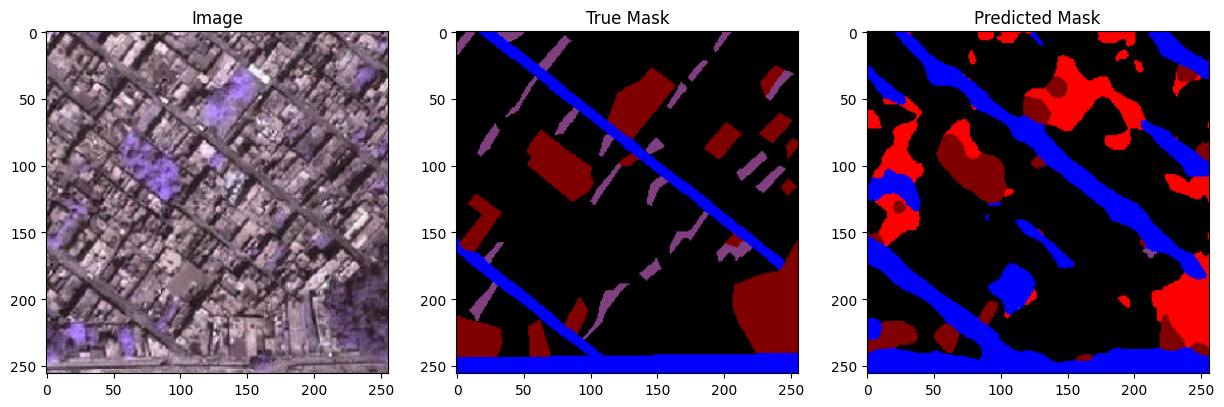

In [ ]:
# ✅ STEP 9: Visualize Predictions
import matplotlib.pyplot as plt

def decode_segmentation(mask):
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_id, color in category_colors.items():
        color_mask[mask == class_id] = color
    return color_mask

# Show prediction
sample_idx = 4  # or any index you choose

pred_mask = model.predict(np.expand_dims(X_test[sample_idx], axis=0))
pred_mask = np.argmax(pred_mask.squeeze(), axis=-1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(X_test[sample_idx])

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(decode_segmentation(y_test[sample_idx]))

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(decode_segmentation(pred_mask))
plt.show()


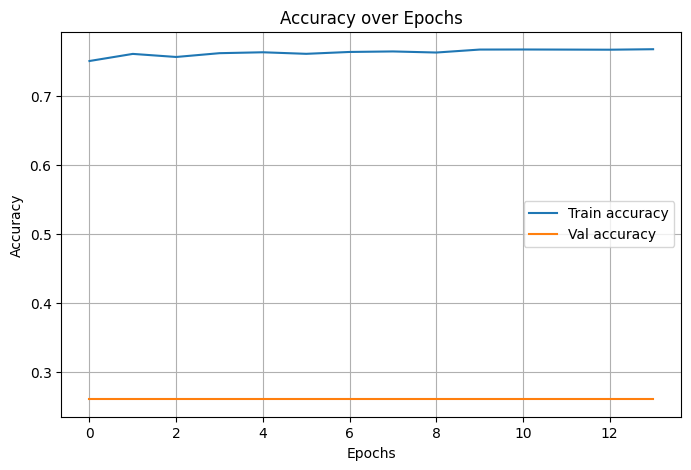

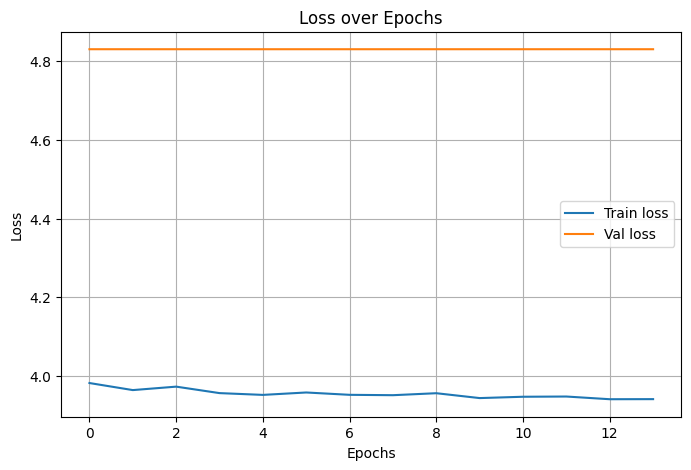

KeyError: 'val_learning_rate'

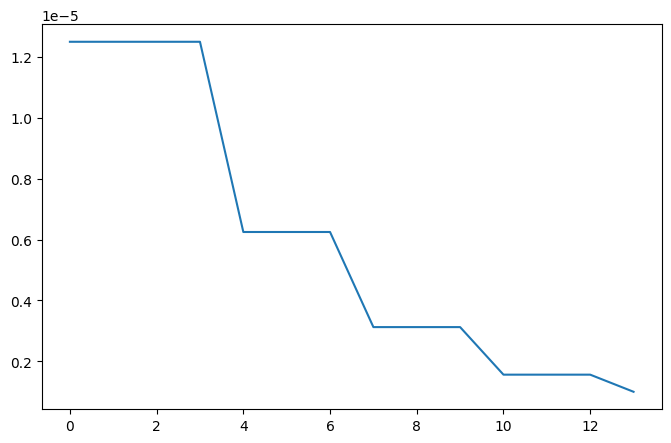

In [ ]:
# ✅ STEP 9: Plot Training Curves (Loss, Accuracy, etc.)
def plot_training_history(history):
    metrics = [m for m in history.history.keys() if not m.startswith('val_')]  # e.g. ['loss', 'accuracy']
    for metric in metrics:
        plt.figure(figsize=(8, 5))
        plt.plot(history.history[metric], label='Train ' + metric)
        plt.plot(history.history['val_' + metric], label='Val ' + metric)
        plt.title(f'{metric.capitalize()} over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.show()

plot_training_history(history)


In [ ]:
# ✅ STEP 10: Save the Model
model_save_path = '/content/drive/MyDrive/unet_resnet50_model.h5'
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")


Foe F score and Confusion Matrix

In [ ]:
# from sklearn.metrics import f1_score, confusion_matrix, classification_report
# import seaborn as sns

# # Choose how many samples to evaluate
# num_samples = 100  # Adjust if needed
# y_true_all = []
# y_pred_all = []

# for i in range(num_samples):
#     img = np.expand_dims(X_test_prep[i], axis=0)
#     pred = model.predict(img)

#     pred_label = np.argmax(pred.squeeze(), axis=-1).flatten()
#     true_label = np.argmax(y_test[i], axis=-1).flatten()

#     y_pred_all.extend(pred_label)
#     y_true_all.extend(true_label)

# # ✅ F1 Score (Macro, Weighted, etc.)
# print("F1 Score (macro):", f1_score(y_true_all, y_pred_all, average='macro'))
# print("F1 Score (weighted):", f1_score(y_true_all, y_pred_all, average='weighted'))

# # ✅ Classification Report
# print("\nClassification Report:")
# print(classification_report(y_true_all, y_pred_all, digits=3))

# # ✅ Confusion Matrix
# cm = confusion_matrix(y_true_all, y_pred_all, labels=np.arange(NUM_CLASSES))

# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=list(category_colors.keys()),
#             yticklabels=list(category_colors.keys()))
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━

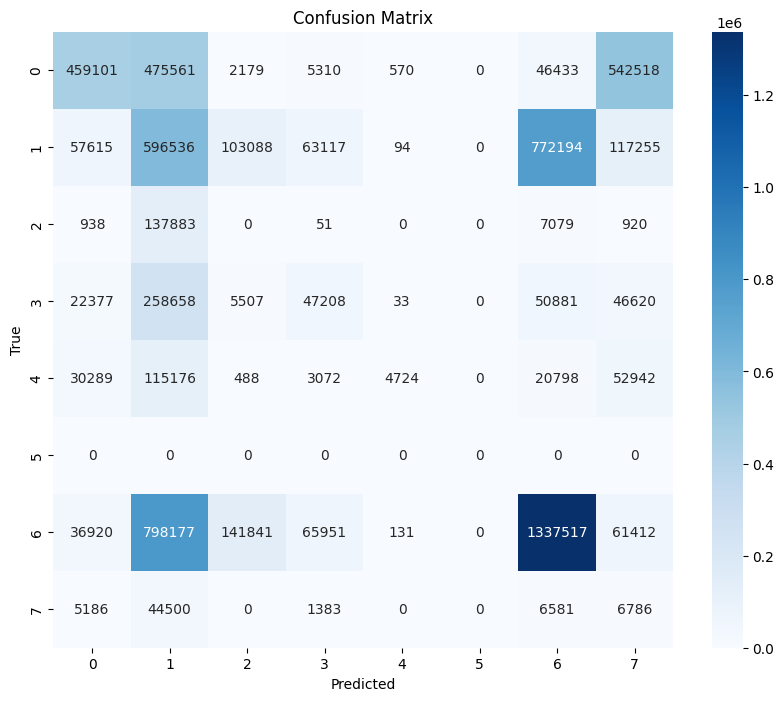

In [ ]:
# ✅ F1 and Confusion Matrix (final evaluation)
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns

y_true_all, y_pred_all = [], []

for i in range(100):  # or fewer if RAM is tight
    img = np.expand_dims(X_test[i], axis=0)
    pred = model.predict(img)
    pred_label = np.argmax(pred.squeeze(), axis=-1).flatten()
    true_label = y_test[i].flatten()  # ✅ FIXED: don't use argmax

    y_pred_all.extend(pred_label)
    y_true_all.extend(true_label)

# Print F1 scores
print("F1 Score (macro):", f1_score(y_true_all, y_pred_all, average='macro'))
print("F1 Score (weighted):", f1_score(y_true_all, y_pred_all, average='weighted'))

print("\nClassification Report:")
print(classification_report(y_true_all, y_pred_all, digits=3))

# Plot Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
